In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import pandas as pd
from collections import OrderedDict

from torch import optim
from torch import nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.autograd import Variable
import torchvision
from torchvision import datasets,transforms,models
from PIL import Image
from fractions import Fraction

import time
import h5py

import help

## 多模型特征向量融合

加载已训练过的模型

In [20]:
loadmodel_inception_v3 = help.load_checkpoint(help.inception_v3_checkpoint_path,'inception_v3')
loadmodel_resnet50 = help.load_checkpoint(help.resnet50_checkpoint_path,'resnet50')
loadmodel_densenet121 = help.load_checkpoint(help.densenet121_checkpoint_path,'densenet121')

获取训练集，验证集，测试集，kaggle测试集的各模型特征向量以及标签值(kaggle测试集返回的标签值指的是对应的图片id)

In [19]:
def get_all_feature_vector(model,model_name,model_feature_outsize,size):
    
    train_cat_filelist = os.listdir(os.path.join(help.train_dir,help.cat_dir))
    train_dog_filelist = os.listdir(os.path.join(help.train_dir,help.dog_dir))
    val_cat_filelist = os.listdir(os.path.join(help.val_dir,help.cat_dir))
    val_dog_filelist = os.listdir(os.path.join(help.val_dir,help.dog_dir))
    datatest_cat_filelist = os.listdir(os.path.join(help.datatest_dir,help.cat_dir))
    datatest_dog_filelist = os.listdir(os.path.join(help.datatest_dir,help.dog_dir))
    
    test_filelist = os.listdir(help.test_dir)
    
    X_train_cat,y_train_cat = get_one_feature_vector(model,model_name,model_feature_outsize,os.path.join(help.train_dir,help.cat_dir),train_cat_filelist,size)
    X_train_dog,y_train_dog = get_one_feature_vector(model,model_name,model_feature_outsize,os.path.join(help.train_dir,help.dog_dir),train_dog_filelist,size)
    X_val_cat,y_val_cat = get_one_feature_vector(model,model_name,model_feature_outsize,os.path.join(help.val_dir,help.cat_dir),val_cat_filelist,size)
    X_val_dog,y_val_dog = get_one_feature_vector(model,model_name,model_feature_outsize,os.path.join(help.val_dir,help.dog_dir),val_dog_filelist,size)
    X_test_cat,y_test_cat = get_one_feature_vector(model,model_name,model_feature_outsize,os.path.join(help.datatest_dir,help.cat_dir),datatest_cat_filelist,size)
    X_test_dog,y_test_dog = get_one_feature_vector(model,model_name,model_feature_outsize,os.path.join(help.datatest_dir,help.dog_dir),datatest_dog_filelist,size)
    
    X_kaggle_test,y_kaggle_test = get_one_feature_vector(model,model_name,model_feature_outsize,help.test_dir,test_filelist,size)
    
    X_train = np.append(X_train_cat,X_train_dog,axis=0)
    y_train = np.append(y_train_cat,y_train_dog,axis=0)
    X_val = np.append(X_val_cat,X_val_dog,axis=0)
    y_val = np.append(y_val_cat,y_val_dog,axis=0)
    X_test = np.append(X_test_cat,X_test_dog,axis=0)
    y_test = np.append(y_test_cat,y_test_dog,axis=0)
    
    return X_train,y_train,X_val,y_val,X_test,y_test,X_kaggle_test,y_kaggle_test
        
def get_one_feature_vector(model,model_name,model_feature_outsize,dirname,filelist,size):
    #修改模型分类器，获取特征向量
    fc = nn.Sequential(nn.ReLU())
    if model_name == 'densenet121':
        model.classifier = fc
    else:
        model.fc = fc
    transforms1 = transforms.Compose([transforms.Resize(int(size*1.14)),
                                transforms.CenterCrop(size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])])
    
    features = np.zeros(shape=(len(filelist), model_feature_outsize))
    labels = np.zeros(shape=(len(filelist),))
    
    model.eval()
    for i in range(len(filelist)):
        img = Image.open(os.path.join(dirname,filelist[i]))
        tensor_image = transforms1(img)
        img = tensor_image.unsqueeze(0)
        if torch.cuda.is_available():
            img = img.cuda()
            model.cuda()
        else:
            img = img.cpu()
            model.cpu()

        # 将输入变为变量
        img = Variable(img)
        torch.no_grad()
        out = model(img)
        out = np.squeeze(out.cpu().detach().numpy())
        
        features[i] = out
        
        if filelist[i].startswith('cat'):
            labels[i] = 0
        elif filelist[i].startswith('dog'):
            labels[i] = 1
        else:
            #kaggle 测试集，返回的是各图片id
            labels[i] = filelist[i].split('.')[0]
    
    
    return features,labels

In [21]:
X_train_densenet121,y_train_densenet121,X_val_densenet121,y_val_densenet121,X_test_densenet121,y_test_densenet121,X_kaggle_test_densenet121,y_kaggle_test_densenet121 = get_all_feature_vector(loadmodel_densenet121,'densenet121',1024,224)
X_train_resnet50,y_train_resnet50,X_val_resnet50,y_val_resnet50,X_test_resnet50,y_test_resnet50,X_kaggle_test_resnet50,y_kaggle_test_resnet50 = get_all_feature_vector(loadmodel_resnet50,'resnet50',2048,224)
X_train_inception_v3,y_train_inception_v3,X_val_inception_v3,y_val_inception_v3,X_test_inception_v3,y_test_inception_v3,X_kaggle_test_inception_v3,y_kaggle_test_inception_v3 = get_all_feature_vector(loadmodel_inception_v3,'inception_v3',2048,299)

将各模型的特征向量融合，然后存储到h5文件里便于下次直接取用

In [15]:
#水平合并各模型的特征向量(densenet121)1024 + (resnet50)2048 + (inception_v3)2048 = 5120列特征向量
X_train = np.hstack([X_train_densenet121,X_train_resnet50,X_train_inception_v3])
y_train = y_train_densenet121
X_val = np.hstack([X_val_densenet121,X_val_resnet50,X_val_inception_v3])
y_val = y_val_densenet121
X_test = np.hstack([X_test_densenet121,X_test_resnet50,X_test_inception_v3])
y_test = y_test_densenet121
X_kaggle_test = np.hstack([X_kaggle_test_densenet121,X_kaggle_test_resnet50,X_kaggle_test_inception_v3])
y_kaggle_test = y_kaggle_test_densenet121
#将获取到的特征向量保存为h5文件，方便后续取用
with h5py.File(help.feature_h5,'w') as h:        
    h.create_dataset("X_train", data=X_train)
    h.create_dataset("y_train", data=y_train)
    h.create_dataset("X_val", data=X_val)
    h.create_dataset("y_val", data=y_val)
    h.create_dataset("X_test", data=X_test)
    h.create_dataset("y_test", data=y_test)
    h.create_dataset("X_kaggle_test", data=X_kaggle_test)
    h.create_dataset("y_kaggle_test", data=y_kaggle_test)

从h5文件里读取存储的融合的特征向量

In [2]:
#读取储存的特征向量文件
with h5py.File(help.feature_h5, 'r') as h:
    X_train_5 = np.array(h['X_train'])
    y_train_5 = np.array(h['y_train'])
    X_val_5 = np.array(h['X_val'])
    y_val_5 = np.array(h['y_val'])
    X_test_5 = np.array(h['X_test'])
    y_test_5 = np.array(h['y_test'])
    X_kaggle_test_5 = np.array(h['X_kaggle_test'])
    y_kaggle_test_5 = np.array(h['y_kaggle_test'])

将取出来的特征向量转化为tensor，用于分类器模型的输入

In [3]:

X_train_tensor = torch.tensor(X_train_5,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_5,dtype=torch.long)
X_val_tensor = torch.tensor(X_val_5,dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_5,dtype=torch.long)
X_test_tensor = torch.tensor(X_test_5,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_5,dtype=torch.long)
X_kaggle_test_tensor = torch.tensor(X_kaggle_test_5,dtype=torch.float32)
y_kaggle_test_tensor = torch.tensor(y_kaggle_test_5,dtype=torch.long)

构建一个简单的分类器模型，输入为融合的1特征向量(5120,)输出为(2,)

In [4]:
input_size = 5120
hidden_size = [2048,2048]
output_size = 2
#自定义分类器
merge_model = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(input_size,hidden_size[0])),
    ('relu1',nn.ReLU()),
    ('dropout1',nn.Dropout(p=0.5)),
    ('fc2',nn.Linear(hidden_size[0],hidden_size[1])),
    ('relu2',nn.ReLU()),
    ('dropout2',nn.Dropout(p=0.5)),
    ('output',nn.Linear(hidden_size[1],output_size)),
    ('softmax',nn.LogSoftmax(dim=1))
]))
merge_model.fc1.bias.data.fill_(0)
merge_model.fc1.weight.data.normal_(std=0.01)
merge_model.fc2.bias.data.fill_(0)
merge_model.fc2.weight.data.normal_(std=0.01)
merge_model.output.bias.data.fill_(0)
merge_model.output.weight.data.normal_(std=0.01)
merge_model

Sequential(
  (fc1): Linear(in_features=5120, out_features=2048, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5)
  (output): Linear(in_features=2048, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

In [5]:
class MergeTestDataset(torch.utils.data.Dataset):
    
    def __init__(self,features=None,labels=None):
        self.features=features
        self.labels=labels

    #返回整个数据集大小
    def __len__(self):
        return len(self.labels)
    
    #根据索引index返回dataset[index]
    def __getitem__(self,index):
        #img_id即为图片名称
        feature = self.features[index]
        label = self.labels[index]
        
        return feature,label

使用自定义Dataset加载融合的特征向量数据

In [6]:
train_datasets = MergeTestDataset(X_train_tensor,y_train_tensor)
train_dataloaders = torch.utils.data.DataLoader(train_datasets,batch_size=64,shuffle=True)

val_datasets = MergeTestDataset(X_val_tensor,y_val_tensor)
val_dataloaders = torch.utils.data.DataLoader(val_datasets,batch_size=32)

datatest_datasets = MergeTestDataset(X_test_tensor,y_test_tensor)
datatest_dataloaders = torch.utils.data.DataLoader(datatest_datasets,batch_size=8)

kaggle_test_datasets = MergeTestDataset(X_kaggle_test_tensor,y_kaggle_test_tensor)
kaggle_test_dataloaders = torch.utils.data.DataLoader(kaggle_test_datasets)

In [7]:
criterion = nn.NLLLoss()
#optimizer = optim.Adam(merge_model.parameters(),lr=0.01)


In [8]:
def do_deep_learning(model,train_dataloaders,valid_dataloaders,epochs,print_every,criterion,checkpoint_path,device='cpu'):
    '''
        model:创建的模型
        model_name:模型名称，便于保存模型时选择保存的方法
        train_dataloaders:训练集
        epochs:训练次数
        print_every:训练每隔多少次打印一次结果
        criterion:误差函数
        checkpoint_path:模型保存的地址
        device:训练使用的是cpu还是GPU
    
    '''
    
    epochs = epochs
    print_every = print_every
    steps = 0
    n_epochs_stop = 10
    min_val_loss = np.Inf
    epochs_no_improve = 0
    point = 0
    
    model.to(device)
    
    for e in range(epochs):
        model.train()
        running_loss = 0
        optimizer = optim.Adam(model.parameters(),lr=dynamic_learning_rate(e))
        for ii,(images,labels) in enumerate(train_dataloaders):
            steps += 1
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()
            
            outputs = model.forward(images)
            
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                point += 1
                accuracy = 0
                val_loss = 0
                with torch.no_grad():
                    model.eval()
                    for ii,(images,labels) in enumerate(valid_dataloaders):
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        val_loss += criterion(outputs,labels).item()
                        
                        ps = torch.exp(outputs).data
                        equality = (labels.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean() 
                
                print('Epochs: {}/{}...'.format(e+1,epochs),
                     'Trianing Loss:{:.3f}...'.format(running_loss/print_every),
                     'Val Loss:{:.3f}...'.format(val_loss/len(valid_dataloaders)),
                     'Val Accuracy:{:.3f}'.format(accuracy/len(valid_dataloaders)))
                
                model_indicators.loc[model_indicators.shape[0]] = [point,running_loss/print_every,val_loss/len(valid_dataloaders)]
                #早期停止,根据模型训练过程中在验证集上的损失来保存表现最好的模型
                if val_loss < min_val_loss:
                    torch.save(model,checkpoint_path)
                    epochs_no_improve = 0
                    min_val_loss = val_loss
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == n_epochs_stop:
                        print('Early stopping!')
                
                running_loss = 0
                model.train()
                

根据训练的epoch调整学习率，实现动态控制

In [9]:
def dynamic_learning_rate(epoch):
    if epoch < 5:
        return 0.00001
    elif epoch < 10:
        return 0.000005
    elif epoch < 15:
        return 0.000001
    else:
        return 0.0000001

In [10]:
model_indicators = pd.DataFrame(columns=['point','train_loss','val_loss'])
EPOCHS = 20
print_every = 100
#optimizer = optim.Adam(merge_model.parameters(),lr=0.00001)
start = time.time()
do_deep_learning(merge_model,train_dataloaders,val_dataloaders,EPOCHS,print_every,criterion,help.merge_model_path,help.device)
end = time.time()
runing_time = end - start
print('MergeModel Training time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

Epochs: 1/20... Trianing Loss:0.406... Val Loss:0.111... Val Accuracy:0.989
Epochs: 1/20... Trianing Loss:0.078... Val Loss:0.042... Val Accuracy:0.989
Epochs: 1/20... Trianing Loss:0.045... Val Loss:0.032... Val Accuracy:0.991
Epochs: 2/20... Trianing Loss:0.028... Val Loss:0.028... Val Accuracy:0.990
Epochs: 2/20... Trianing Loss:0.029... Val Loss:0.028... Val Accuracy:0.992
Epochs: 2/20... Trianing Loss:0.029... Val Loss:0.025... Val Accuracy:0.990
Epochs: 3/20... Trianing Loss:0.018... Val Loss:0.025... Val Accuracy:0.992
Epochs: 3/20... Trianing Loss:0.020... Val Loss:0.024... Val Accuracy:0.992
Epochs: 3/20... Trianing Loss:0.028... Val Loss:0.025... Val Accuracy:0.991
Epochs: 4/20... Trianing Loss:0.010... Val Loss:0.023... Val Accuracy:0.990
Epochs: 4/20... Trianing Loss:0.020... Val Loss:0.024... Val Accuracy:0.992
Epochs: 4/20... Trianing Loss:0.022... Val Loss:0.025... Val Accuracy:0.992
Epochs: 5/20... Trianing Loss:0.008... Val Loss:0.024... Val Accuracy:0.992
Epochs: 5/20

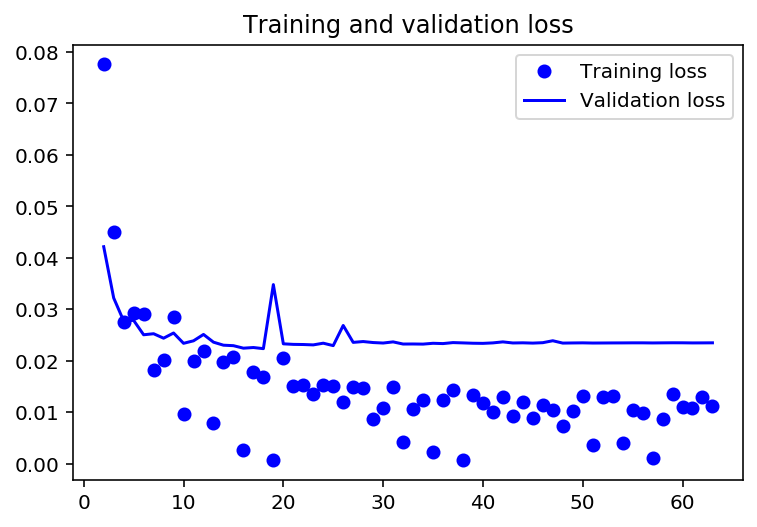

In [11]:
model_indicators_mergemodel = model_indicators.copy()
#画Train Loss与Val Loss的走向图
help.plt_result(model_indicators_mergemodel[1:])

重新加载预训练模型，并在测试集上进行测试

In [12]:
loadmodel_merge = torch.load(help.merge_model_path)
help.check_logloss_on_test(loadmodel_merge,datatest_dataloaders,criterion,help.device)

Test Loss:0.023... Test Accuracy:0.990


## 在kaggle给的测试集上测试，生成结果文件

In [13]:
help.save_result(kaggle_test_dataloaders,loadmodel_merge,help.device,help.optimalmodel_merge)

0 pictures have been predicted
----------------------------------------
1250 pictures have been predicted
----------------------------------------
2500 pictures have been predicted
----------------------------------------
3750 pictures have been predicted
----------------------------------------
5000 pictures have been predicted
----------------------------------------
6250 pictures have been predicted
----------------------------------------
7500 pictures have been predicted
----------------------------------------
8750 pictures have been predicted
----------------------------------------
10000 pictures have been predicted
----------------------------------------
11250 pictures have been predicted
----------------------------------------
Test time is 0m 32s


将训练好的 $\color{blue}{特征向量融合}$ 模型生成的结果提交到kaggle，得分为 $\color{red}{0.04775}$ ,已经满足项目预期

In [2]:
loadmodel_inception_v3 = help.load_checkpoint(help.inception_v3_checkpoint_path,'inception_v3',help.device)
loadmodel_resnet50 = help.load_checkpoint(help.resnet50_checkpoint_path,'resnet50',help.device)
loadmodel_densenet121 = help.load_checkpoint(help.densenet121_checkpoint_path,'densenet121',help.device)
loadmodel_merge = torch.load(help.merge_model_path,map_location='cpu')

F:\Python\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
F:\Python\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
F:\Python\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `t

In [14]:
def one_pic_get_feature(model,model_name,dirname,image_name,size):
    fc = nn.Sequential(nn.ReLU())
    if model_name == 'densenet121':
        model.classifier = fc
    else:
        model.fc = fc
    transforms1 = transforms.Compose([transforms.Resize(int(size*1.14)),
                                transforms.CenterCrop(size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])])
    
    model.eval()
    img = Image.open(os.path.join(dirname,image_name))
    tensor_image = transforms1(img)
    img = tensor_image.unsqueeze(0)
    if torch.cuda.is_available():
        img = img.cuda()
        model.cuda()
    else:
        img = img.cpu()
        model.cpu()

    # 将输入变为变量
    img = Variable(img)
    torch.no_grad()
    out = model(img)
    feature = np.squeeze(out.cpu().detach().numpy())
        
    return feature

def mergemodel_predict(dirname,image_name,topk=2):
    
    feature_densenet121 = one_pic_get_feature(loadmodel_densenet121,'densenet121',dirname,image_name,224)
    feature_resnet50 = one_pic_get_feature(loadmodel_resnet50,'resnet50',dirname,image_name,224)
    feature_inception_v3 = one_pic_get_feature(loadmodel_inception_v3,'inception_v3',dirname,image_name,299)
    merge_feaature = np.hstack([feature_densenet121,feature_resnet50,feature_inception_v3])
    merge_feaature = torch.tensor(merge_feaature,dtype=torch.float32)
    merge_feaature = merge_feaature.unsqueeze(0)
    if torch.cuda.is_available():
        merge_feaature = merge_feaature.cuda()
        loadmodel_merge.cuda()
    else:
        merge_feaature = merge_feaature.cpu()
        loadmodel_merge.cpu()

    # 将输入变为变量
    merge_feaature = Variable(merge_feaature)

    torch.no_grad()
    output = loadmodel_merge(merge_feaature)
    output = torch.exp(output)
    probs,indexs = output.topk(topk)

    #tensor转为numpy，并降维
    probs = np.squeeze(probs.cpu().detach().numpy())
    indexs = np.squeeze(indexs.cpu().detach().numpy())
    classes = []
    new_dict = {v:k for k,v in help.classes_index.items()}
    for i in range(len(indexs)):
        classes.append(new_dict.get(indexs[i]))

    return probs,classes

def display_samples(dirname,sample_num):
    samples = np.random.choice(range(1,12500),size=sample_num,replace=False)
    print(samples)
    fig = plt.figure(figsize=(16,(sample_num//5 + 1)*3))
    
    for index in range(len(samples)):
        probs, classes = mergemodel_predict(dirname,'{}.jpg'.format(samples[index]))
        plt.subplot(sample_num//5 + 1,5,index+1)
        plt.title('{}:{:.3f},{}:{:.3f}'.format(classes[0],probs[0],classes[1],probs[1]))
        img = Image.open(os.path.join(dirname,'{}.jpg'.format(samples[index])))
        img = img.resize((224,224))
        plt.imshow(img)
    
    #使得子图横纵坐标更加紧凑，主要用于自动调整图区的大小以及间距，使所有的绘图及其标题、坐标轴标签等都可以不重叠的完整显示在画布上。
    fig.tight_layout()
    plt.show()

从kaggle 测试集中随机抽取10张图片，使用特征向量融合模型进行预测并显示

[ 4199  6578  3305  4509  1234  6468   307 11944  2583  3452]


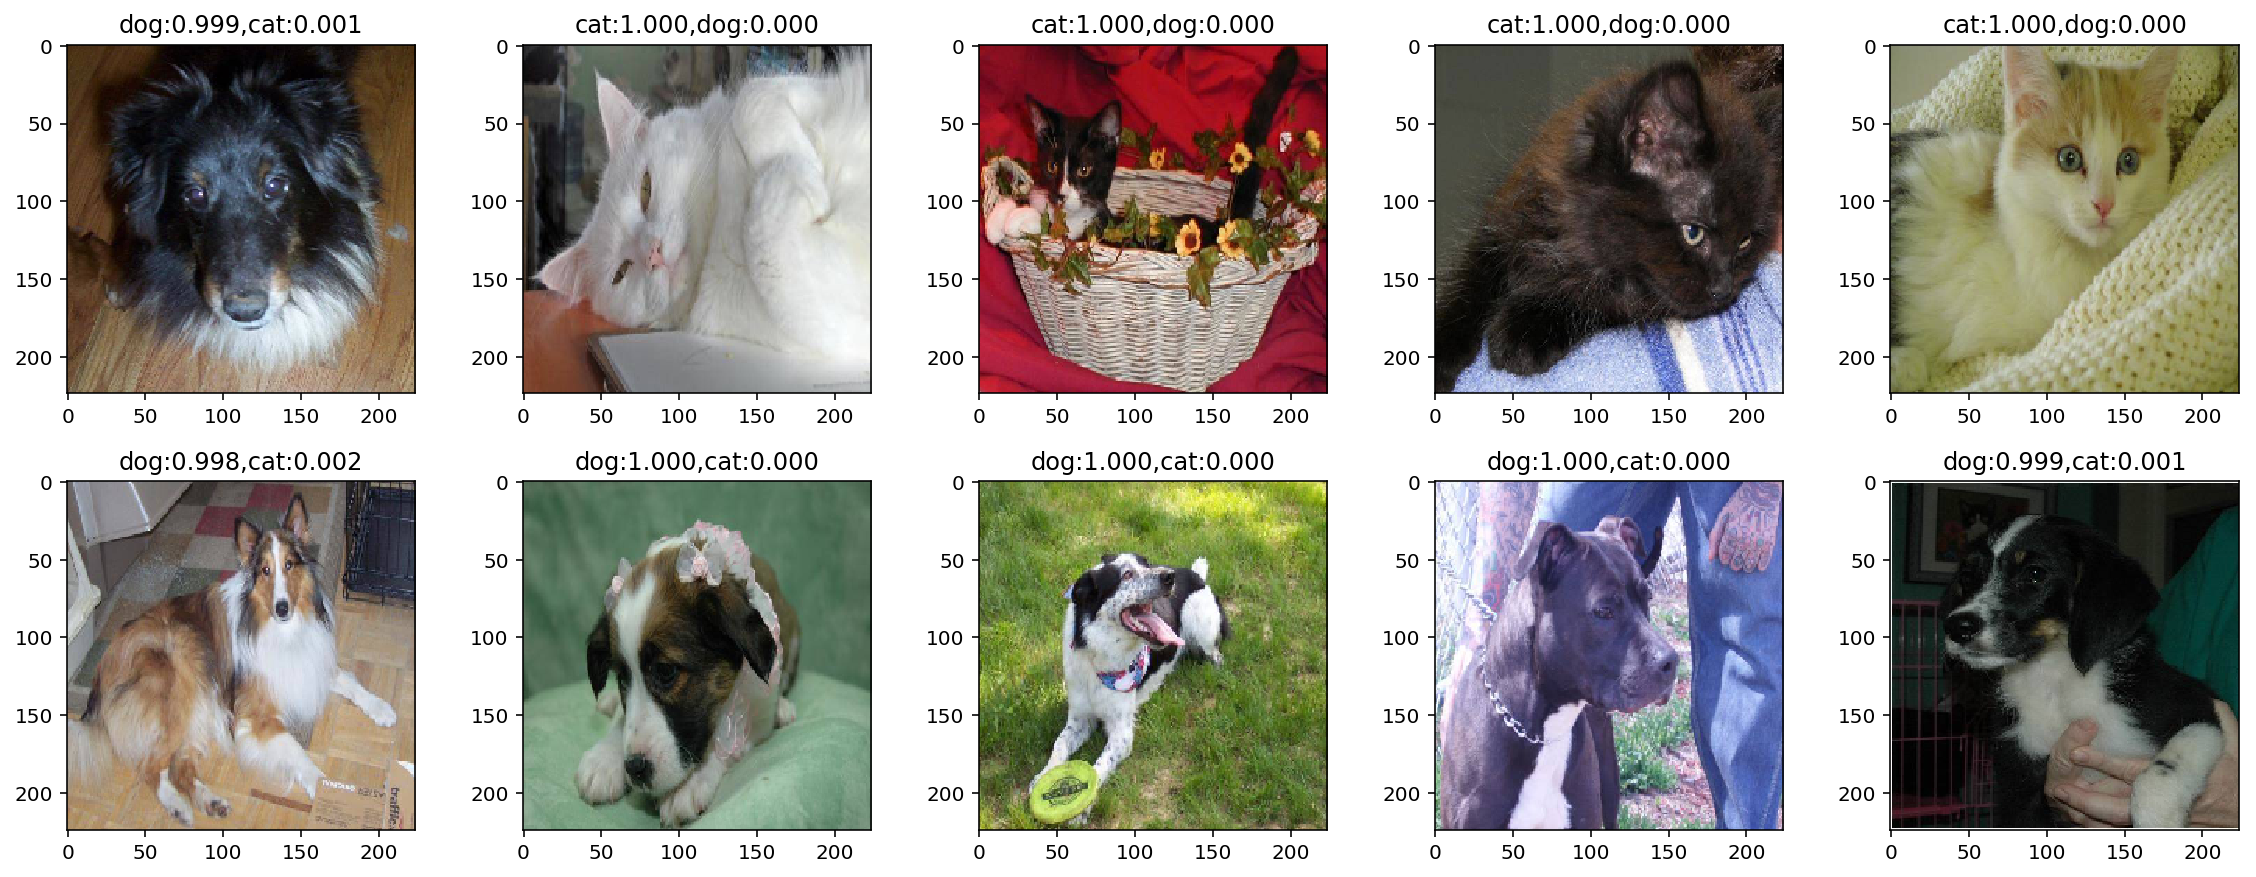

In [15]:
display_samples(help.test_dir,10)